# 1) Importing required libraries and dataset

In [1]:
# Data and Visualization libraries
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import json
import kagglehub

# NLP preprocessing
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


/home/mystic_rustacean/anaconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download dataset from kagglehub
kag_path = kagglehub.dataset_download("rmisra/news-category-dataset")
print("Kaggle Path to the News Category dataset:", kag_path)

Kaggle Path to the News Category dataset: /home/mystic_rustacean/.cache/kagglehub/datasets/rmisra/news-category-dataset/versions/3


In [3]:
# Loading json file and converting into dataframe using pandas

d=[]
with open("./News_Category_Dataset_v3.json","r") as a:
    for news in a:
        d.append(json.loads(news))

df=pd.DataFrame(d)

# 2) Data preprocessing

In [4]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               209527 non-null  object
 1   headline           209527 non-null  object
 2   category           209527 non-null  object
 3   short_description  209527 non-null  object
 4   authors            209527 non-null  object
 5   date               209527 non-null  object
dtypes: object(6)
memory usage: 9.6+ MB


There are 6 attributes in the dataset which give information about news link, news headline, news  category, short description, news author and date of news. All the attributes are object type.

In [6]:
df.isna().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

There are no missing values in the entire dataset.

In [7]:
df.describe().T # brief description of dataset

,count,unique,top,freq
link,209527,209486,https://www.huffingtonpost.comhttp://stylelike...,2
headline,209527,207996,Sunday Roundup,90
category,209527,42,POLITICS,35602
short_description,209527,187022,,19712
authors,209527,29169,,37418
date,209527,3890,2012-02-21,100


In [8]:
# Check shape of dataset
df.shape

(209527, 6)

In [9]:
# Dropping all unnecessary attributes from the dataset 
# Keeping only 2 major attributes which contribute in news classification

df=df[['headline','category']]
df.head()

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS


On the basis of headline, we will NLP to predict the category of the respective news.

In [10]:
# Checking for duplicate values
df.duplicated().sum()

np.int64(1419)

In [11]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [12]:
df.shape

(208108, 2)

Text(0.5, 1.0, 'Category Distribution')

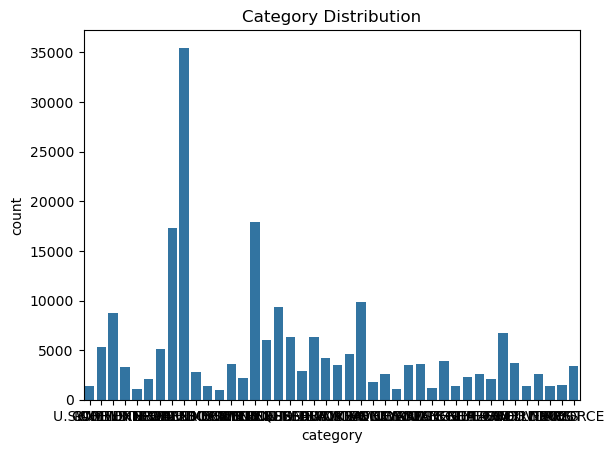

In [13]:
sns.countplot(x=df.category)
plt.title("Category Distribution")

In [14]:
x=df['headline']
x.head()

0    Over 4 Million Americans Roll Up Sleeves For O...
1    American Airlines Flyer Charged, Banned For Li...
2    23 Of The Funniest Tweets About Cats And Dogs ...
3    The Funniest Tweets From Parents This Week (Se...
4    Woman Who Called Cops On Black Bird-Watcher Lo...
Name: headline, dtype: object

In [15]:
y=df['category']
y.head()

0    U.S. NEWS
1    U.S. NEWS
2       COMEDY
3    PARENTING
4    U.S. NEWS
Name: category, dtype: object

In [16]:
copy=df.copy()
copy.reset_index(inplace=True,drop=True)
copy.head()

,headline,category
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY
3,The Funniest Tweets From Parents This Week (Se...,PARENTING
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS


In [17]:
copy['headline'][3]

'The Funniest Tweets From Parents This Week (Sept. 17-23)'

# 3) NLP Algorithm

In [18]:
# import nltk

# nltk.download('stopwords')

In [19]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

porter = PorterStemmer()
corpus = []

for i in range(len(copy)):
    news_head = re.sub('[^a-zA-Z]', ' ', copy['headline'][i])  
    news_head = news_head.lower() 
    news_head = news_head.split()
    news_head = [porter.stem(word) for word in news_head if word not in stopwords.words('english')] 
    news_head = ' '.join(news_head)
    corpus.append(news_head)

In [20]:
corpus[:1]

['million american roll sleev omicron target covid booster']

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=500,ngram_range=(1,5))
x_json = cv.fit_transform(corpus).toarray()
x_json

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(208108, 500))

In [22]:
df_json=pd.concat([df,pd.DataFrame(x_json)],axis=1)
df_json

,headline,category,0,1,2,3,4,5,6,7,...,490,491,492,493,494,495,496,497,498,499
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207718,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207916,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207960,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208096,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4) Splitting the dataset

In [23]:
x_train,x_test,y_train,y_test = train_test_split(df_json.drop(['category'],axis=1),df_json['category'],test_size=0.3,random_state=42)

# 5) Fitting model and predicting output

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer(max_features=500, ngram_range=(1,5))
X = vectorizer.fit_transform(corpus)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB(alpha=0.01)
model.fit(X_train, y_train) 

MultinomialNB(alpha=0.01)

In [25]:
y_pred = model.predict(X_test)
y_pred

array(['PARENTING', 'QUEER VOICES', 'WOMEN', ..., 'ENTERTAINMENT',
       'SCIENCE', 'BUSINESS'], shape=(41622,), dtype='<U14')

In [26]:
# Using different metrics for predicting the output of the model
print("The Classification report of the Model is as follows:")
print(classification_report(y_test,y_pred))

The Classification report of the Model is as follows:
                precision    recall  f1-score   support

          ARTS       0.18      0.11      0.13       265
ARTS & CULTURE       0.27      0.10      0.15       258
  BLACK VOICES       0.36      0.19      0.25       911
      BUSINESS       0.30      0.20      0.24      1165
       COLLEGE       0.33      0.26      0.29       232
        COMEDY       0.43      0.22      0.29      1115
         CRIME       0.32      0.50      0.39       737
CULTURE & ARTS       0.29      0.13      0.18       203
       DIVORCE       0.67      0.53      0.60       694
     EDUCATION       0.30      0.29      0.30       209
 ENTERTAINMENT       0.35      0.45      0.39      3441
   ENVIRONMENT       0.25      0.07      0.11       283
         FIFTY       0.18      0.06      0.09       281
  FOOD & DRINK       0.46      0.40      0.43      1281
     GOOD NEWS       0.32      0.14      0.20       295
         GREEN       0.30      0.15      0.20    

In [27]:
con_mat = confusion_matrix(y_test,y_pred)
print("The Confusion Matrix of the Model is as follows:")
con_mat

The Confusion Matrix of the Model is as follows:


array([[ 28,   9,   3, ...,   1,   0,   2],
       [ 22,  27,   2, ...,   7,   0,   2],
       [  3,   2, 174, ...,  10,   2,   3],
       ...,
       [  0,   4,   8, ..., 133,   2,   0],
       [  0,   1,   4, ...,   9,  83,  33],
       [  1,   2,   2, ...,   3,  16,  36]], shape=(42, 42))

The Heatmap of the Model is as follows:


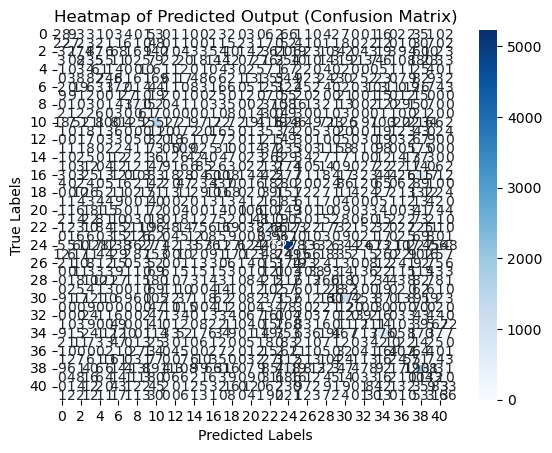

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

con_mat = confusion_matrix(y_test, y_pred)

print("The Heatmap of the Model is as follows:")
sns.heatmap(con_mat, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Heatmap of Predicted Output (Confusion Matrix)")
plt.show()

In [29]:
print("Accuracy score is as follows:")
print(accuracy_score(y_test,y_pred))

Accuracy score is as follows:
0.38700687136610445


# 6) Implementing TF-IDF Vectorizer

TF-IDF combines two components: Term Frequency (TF) and Inverse Document Frequency (IDF).

Term Frequency (TF): Measures how often a word appears in a document. A higher frequency suggests greater importance. If a term appears frequently in a document, it is likely relevant to the document’s content. 

Term Frequency(TF) = (Number of reps of word in a sentence)/(Number of words in sentence)

Inverse Document Frequency(IDF) = log((number of sentence)/(Number of sentence containing the word))


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1,5))
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [31]:
model = MultinomialNB(alpha=0.01)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [32]:
print("Classification report with TF-IDF:")
print(classification_report(y_test, y_pred))

Classification report with TF-IDF:
                precision    recall  f1-score   support

          ARTS       0.17      0.06      0.09       265
ARTS & CULTURE       0.25      0.03      0.06       258
  BLACK VOICES       0.45      0.12      0.19       911
      BUSINESS       0.41      0.16      0.23      1165
       COLLEGE       0.42      0.15      0.22       232
        COMEDY       0.52      0.12      0.19      1115
         CRIME       0.39      0.41      0.40       737
CULTURE & ARTS       0.40      0.05      0.09       203
       DIVORCE       0.76      0.46      0.58       694
     EDUCATION       0.40      0.13      0.19       209
 ENTERTAINMENT       0.31      0.50      0.39      3441
   ENVIRONMENT       0.37      0.05      0.08       283
         FIFTY       0.57      0.01      0.03       281
  FOOD & DRINK       0.52      0.36      0.43      1281
     GOOD NEWS       0.47      0.02      0.05       295
         GREEN       0.33      0.08      0.13       554
HEALTHY LIVI

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

pipe_count = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500, ngram_range=(1,5))),
    ('classifier', MultinomialNB(alpha=0.01))
])

pipe_tfidf = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=500, ngram_range=(1,5))),
    ('classifier', MultinomialNB(alpha=0.01))
])

pipe_tfidf_enhanced = Pipeline([
    ('vectorizer', TfidfVectorizer(
        max_features=500,
        ngram_range=(1,3),
        stop_words='english',
        token_pattern=r'\b[a-zA-Z]{3,}\b',
        sublinear_tf=True,
        norm='l2'
    )),
    ('classifier', MultinomialNB(alpha=0.01))
])

for name, pipe in [('CountVectorizer', pipe_count), 
                   ('TF-IDF', pipe_tfidf), 
                   ('Enhanced TF-IDF', pipe_tfidf_enhanced)]:
    print(f"\nC {name}:")
    pipe.fit(corpus, y)
    y_pred = pipe.predict(corpus)
    print(classification_report(y, y_pred))


C CountVectorizer:
                precision    recall  f1-score   support

          ARTS       0.26      0.14      0.19      1509
ARTS & CULTURE       0.32      0.11      0.17      1338
  BLACK VOICES       0.39      0.20      0.26      4574
      BUSINESS       0.33      0.20      0.25      5980
       COLLEGE       0.36      0.34      0.35      1144
        COMEDY       0.42      0.22      0.29      5343
         CRIME       0.33      0.51      0.40      3557
CULTURE & ARTS       0.40      0.17      0.24      1054
       DIVORCE       0.68      0.54      0.61      3420
     EDUCATION       0.31      0.32      0.31      1014
 ENTERTAINMENT       0.35      0.45      0.39     17321
   ENVIRONMENT       0.34      0.10      0.16      1372
         FIFTY       0.20      0.06      0.09      1401
  FOOD & DRINK       0.44      0.39      0.41      6335
     GOOD NEWS       0.31      0.14      0.19      1398
         GREEN       0.27      0.17      0.21      2617
HEALTHY LIVING       0.19  

In [34]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

X = vectorizer.fit_transform(corpus)
y = np.array(y) 

X_dense = X.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)

print("\nClassification analysis report with Gaussian Naive Bayes:")
print(classification_report(y_test, y_pred_gnb))


Classification analysis report with Gaussian Naive Bayes:
                precision    recall  f1-score   support

          ARTS       0.01      0.04      0.02       265
ARTS & CULTURE       0.02      0.03      0.02       258
  BLACK VOICES       0.00      0.00      0.00       911
      BUSINESS       0.00      0.00      0.00      1165
       COLLEGE       0.01      0.09      0.02       232
        COMEDY       0.57      0.03      0.05      1115
         CRIME       0.39      0.08      0.14       737
CULTURE & ARTS       0.01      0.79      0.02       203
       DIVORCE       0.37      0.14      0.20       694
     EDUCATION       0.01      0.68      0.03       209
 ENTERTAINMENT       0.53      0.00      0.00      3441
   ENVIRONMENT       0.04      0.08      0.05       283
         FIFTY       0.02      0.23      0.03       281
  FOOD & DRINK       0.45      0.08      0.14      1281
     GOOD NEWS       0.09      0.18      0.12       295
         GREEN       0.08      0.01      0.0